<a href="https://colab.research.google.com/github/moonarchive/Coding3/blob/main/rime2flower.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# instancenormalization

Referenced code from: https://github.com/keras-team/keras-contrib/blob/master/keras_contrib/layers/normalization/instancenormalization.py

In [1]:
from keras.layers import Layer, InputSpec
from keras import initializers, regularizers, constraints
from keras import backend as K

In [2]:
class InstanceNormalization(Layer):
    """Instance normalization layer.

    Normalize the activations of the previous layer at each step,
    i.e. applies a transformation that maintains the mean activation
    close to 0 and the activation standard deviation close to 1.

    # Arguments
        axis: Integer, the axis that should be normalized
            (typically the features axis).
            For instance, after a `Conv2D` layer with
            `data_format="channels_first"`,
            set `axis=1` in `InstanceNormalization`.
            Setting `axis=None` will normalize all values in each
            instance of the batch.
            Axis 0 is the batch dimension. `axis` cannot be set to 0 to avoid errors.
        epsilon: Small float added to variance to avoid dividing by zero.
        center: If True, add offset of `beta` to normalized tensor.
            If False, `beta` is ignored.
        scale: If True, multiply by `gamma`.
            If False, `gamma` is not used.
            When the next layer is linear (also e.g. `nn.relu`),
            this can be disabled since the scaling
            will be done by the next layer.
        beta_initializer: Initializer for the beta weight.
        gamma_initializer: Initializer for the gamma weight.
        beta_regularizer: Optional regularizer for the beta weight.
        gamma_regularizer: Optional regularizer for the gamma weight.
        beta_constraint: Optional constraint for the beta weight.
        gamma_constraint: Optional constraint for the gamma weight.

    # Input shape
        Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a Sequential model.

    # Output shape
        Same shape as input.

    # References
        - [Layer Normalization](https://arxiv.org/abs/1607.06450)
        - [Instance Normalization: The Missing Ingredient for Fast Stylization](
        https://arxiv.org/abs/1607.08022)
    """
    def __init__(self,
                 axis=None,
                 epsilon=1e-3,
                 center=True,
                 scale=True,
                 beta_initializer='zeros',
                 gamma_initializer='ones',
                 beta_regularizer=None,
                 gamma_regularizer=None,
                 beta_constraint=None,
                 gamma_constraint=None,
                 **kwargs):
        super(InstanceNormalization, self).__init__(**kwargs)
        self.supports_masking = True
        self.axis = axis
        self.epsilon = epsilon
        self.center = center
        self.scale = scale
        self.beta_initializer = initializers.get(beta_initializer)
        self.gamma_initializer = initializers.get(gamma_initializer)
        self.beta_regularizer = regularizers.get(beta_regularizer)
        self.gamma_regularizer = regularizers.get(gamma_regularizer)
        self.beta_constraint = constraints.get(beta_constraint)
        self.gamma_constraint = constraints.get(gamma_constraint)

    def build(self, input_shape):
        ndim = len(input_shape)
        if self.axis == 0:
            raise ValueError('Axis cannot be zero')

        if (self.axis is not None) and (ndim == 2):
            raise ValueError('Cannot specify axis for rank 1 tensor')

        self.input_spec = InputSpec(ndim=ndim)

        if self.axis is None:
            shape = (1,)
        else:
            shape = (input_shape[self.axis],)

        if self.scale:
            self.gamma = self.add_weight(shape=shape,
                                         name='gamma',
                                         initializer=self.gamma_initializer,
                                         regularizer=self.gamma_regularizer,
                                         constraint=self.gamma_constraint)
        else:
            self.gamma = None
        if self.center:
            self.beta = self.add_weight(shape=shape,
                                        name='beta',
                                        initializer=self.beta_initializer,
                                        regularizer=self.beta_regularizer,
                                        constraint=self.beta_constraint)
        else:
            self.beta = None
        self.built = True

    def call(self, inputs, training=None):
        input_shape = K.int_shape(inputs)
        reduction_axes = list(range(0, len(input_shape)))

        if self.axis is not None:
            del reduction_axes[self.axis]

        del reduction_axes[0]

        mean = K.mean(inputs, reduction_axes, keepdims=True)
        stddev = K.std(inputs, reduction_axes, keepdims=True) + self.epsilon
        normed = (inputs - mean) / stddev

        broadcast_shape = [1] * len(input_shape)
        if self.axis is not None:
            broadcast_shape[self.axis] = input_shape[self.axis]

        if self.scale:
            broadcast_gamma = K.reshape(self.gamma, broadcast_shape)
            normed = normed * broadcast_gamma
        if self.center:
            broadcast_beta = K.reshape(self.beta, broadcast_shape)
            normed = normed + broadcast_beta
        return normed

    def get_config(self):
        config = {
            'axis': self.axis,
            'epsilon': self.epsilon,
            'center': self.center,
            'scale': self.scale,
            'beta_initializer': initializers.serialize(self.beta_initializer),
            'gamma_initializer': initializers.serialize(self.gamma_initializer),
            'beta_regularizer': regularizers.serialize(self.beta_regularizer),
            'gamma_regularizer': regularizers.serialize(self.gamma_regularizer),
            'beta_constraint': constraints.serialize(self.beta_constraint),
            'gamma_constraint': constraints.serialize(self.gamma_constraint)
        }
        base_config = super(InstanceNormalization, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

# cycleGAN_model

Referenced code from: https://github.com/bnsreenu/python_for_microscopists/blob/master/253_254_cycleGAN_monet2photo/254-cycleGAN_model.py

In [3]:
from random import random
from numpy import load
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from tensorflow.keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
from matplotlib import pyplot

### Discriminator Architecture (PatchGAN)



In [6]:
# discriminator model (70x70 patchGAN)
# C64-C128-C256-C512
#After the last layer, conv to 1-dimensional output, followed by a Sigmoid function.  
# The “axis” argument is set to -1 for instance norm. to ensure that features are normalized per feature map.
def define_discriminator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_image = Input(shape=image_shape)
	# C64: 4x4 kernel Stride 2x2
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
	d = LeakyReLU(alpha=0.2)(d)
	# C128: 4x4 kernel Stride 2x2
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256: 4x4 kernel Stride 2x2
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512: 4x4 kernel Stride 2x2 
    # Not in the original paper. Comment this block if you want.
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer : 4x4 kernel but Stride 1x1
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	patch_out = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	# define model
	model = Model(in_image, patch_out)
	# compile model
    #The model is trained with a batch size of one image and Adam opt. 
    #with a small learning rate and 0.5 beta. 
    #The loss for the discriminator is weighted by 50% for each model update.
    #This slows down changes to the discriminator relative to the generator model during training.
	model.compile(loss='mse', optimizer=Adam(lr=0.0002, beta_1=0.5), loss_weights=[0.5])
	return model

### Generator Architecture

In [7]:
# generator a resnet block to be used in the generator
# what resnet block doing is to concatenate the output with the input
# residual block that contains two 3 × 3 convolutional layers with the same number of filters on both layers.
def resnet_block(n_filters, input_layer):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# first convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# second convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	# concatenate merge channel-wise with input layer
	g = Concatenate()([g, input_layer])
	return g

In [8]:
# define the  generator model - encoder-decoder type architecture

#c7s1-k denote a 7×7 Convolution-InstanceNorm-ReLU layer with k filters and stride 1. 
#dk denotes a 3 × 3 Convolution-InstanceNorm-ReLU layer with k filters and stride 2.
# Rk denotes a residual block that contains two 3 × 3 convolutional layers
# uk denotes a 3 × 3 fractional-strided-Convolution InstanceNorm-ReLU layer with k filters and stride 1/2

#The network with 6 residual blocks consists of:
#c7s1-64,d128,d256,R256,R256,R256,R256,R256,R256,u128,u64,c7s1-3

#The network with 9 residual blocks consists of:
#c7s1-64,d128,d256,R256,R256,R256,R256,R256,R256,R256,R256,R256,u128, u64,c7s1-3

def define_generator(image_shape, n_resnet=9):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# c7s1-64
	g = Conv2D(64, (7,7), padding='same', kernel_initializer=init)(in_image)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# d128
	g = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# d256
	g = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# R256
	for _ in range(n_resnet):
		g = resnet_block(256, g)
	# u128
	g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# u64
	g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# c7s1-3
	g = Conv2D(3, (7,7), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	out_image = Activation('tanh')(g)
 	# 'tanh' goes from -1 to 1
	# define model
	model = Model(in_image, out_image)
	return model

### Composite Model

In [9]:
# define a composite model for updating generators by adversarial and cycle loss
#We define a composite model that will be used to train each generator separately. 
def define_composite_model(g_model_1, d_model, g_model_2, image_shape):
	# Make the generator of interest trainable as we will be updating these weights.
    #by keeping other models constant.
    #Remember that we use this same function to train both generators,
    #one generator at a time. 
	g_model_1.trainable = True
	# mark discriminator and second generator as non-trainable
	d_model.trainable = False
	g_model_2.trainable = False
    
	# adversarial loss
	input_gen = Input(shape=image_shape)
	gen1_out = g_model_1(input_gen)
	output_d = d_model(gen1_out)
	# identity loss
	input_id = Input(shape=image_shape)
	output_id = g_model_1(input_id)
	# cycle loss - forward
	output_f = g_model_2(gen1_out)
	# cycle loss - backward
	gen2_out = g_model_2(input_id)
	output_b = g_model_1(gen2_out)
    
	# define model graph
	model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])
	
    # define the optimizer
	opt = Adam(lr=0.0002, beta_1=0.5)
	# compile model with weighting of least squares loss and L1 loss
	model.compile(loss=['mse', 'mae', 'mae', 'mae'], 
               loss_weights=[1, 5, 10, 10], optimizer=opt)
	return model

In [10]:
# load and prepare training images
def load_real_samples(filename):
	# load the dataset
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale the image shape from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

In [11]:
# select a batch of random samples, returns images and target
#Remember that for real images the label (y) is 1. 
def generate_real_samples(dataset, n_samples, patch_shape):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return X, y

In [12]:
# generate a batch of images, returns images and targets
#Remember that for fake images the label (y) is 0. 
def generate_fake_samples(g_model, dataset, patch_shape):
	# generate fake images
	X = g_model.predict(dataset)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

In [13]:
# periodically save the generator models to file
def save_models(step, g_model_AtoB, g_model_BtoA):
	# save the first generator model
	filename1 = 'g_model_AtoB_%06d.h5' % (step+1)
	g_model_AtoB.save(filename1)
	# save the second generator model
	filename2 = 'g_model_BtoA_%06d.h5' % (step+1)
	g_model_BtoA.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

In [14]:
# periodically generate images using the save model and plot input and output images
def summarize_performance(step, g_model, trainX, name, n_samples=5):
	# select a sample of input images
	X_in, _ = generate_real_samples(trainX, n_samples, 0)
	# generate translated images
	X_out, _ = generate_fake_samples(g_model, X_in, 0)
	# scale all pixels from [-1,1] to [0,1]
	X_in = (X_in + 1) / 2.0
	X_out = (X_out + 1) / 2.0
	# plot real images
	for i in range(n_samples):
		pyplot.subplot(2, n_samples, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(X_in[i])
	# plot translated image
	for i in range(n_samples):
		pyplot.subplot(2, n_samples, 1 + n_samples + i)
		pyplot.axis('off')
		pyplot.imshow(X_out[i])
	# save plot to file
	filename1 = '%s_generated_plot_%06d.png' % (name, (step+1))
	pyplot.savefig(filename1)
	pyplot.close()

In [15]:
# update image pool for fake images to reduce model oscillation
# update discriminators using a history of generated images 
#rather than the ones produced by the latest generators.
#Original paper recommended keeping an image buffer that stores 
#the 50 previously created images.

def update_image_pool(pool, images, max_size=50):
	selected = list()
	for image in images:
		if len(pool) < max_size:
			# stock the pool
			pool.append(image)
			selected.append(image)
		elif random() < 0.5:
			# use image, but don't add it to the pool
			selected.append(image)
		else:
			# replace an existing image and use replaced image
			ix = randint(0, len(pool))
			selected.append(pool[ix])
			pool[ix] = image
	return asarray(selected)

### Training

In [16]:
# train cyclegan models
def train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset, epochs=1):
	# define properties of the training run
	n_epochs, n_batch, = epochs, 1  #batch size fixed to 1 as suggested in the paper
	# determine the output square shape of the discriminator
	n_patch = d_model_A.output_shape[1]
	# unpack dataset
	trainA, trainB = dataset
	# prepare image pool for fake images
	poolA, poolB = list(), list()
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
    
	# manually enumerate epochs
	for i in range(n_steps):
		# select a batch of real samples from each domain (A and B)
		X_realA, y_realA = generate_real_samples(trainA, n_batch, n_patch)
		X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch)
		# generate a batch of fake samples using both B to A and A to B generators.
		X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
		X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)
		# update fake images in the pool. Remember that the paper suggstes a buffer of 50 images
		X_fakeA = update_image_pool(poolA, X_fakeA)
		X_fakeB = update_image_pool(poolB, X_fakeB)
        
		# update generator B->A via the composite model
		g_loss2, _, _, _, _  = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])
		# update discriminator for A -> [real/fake]
		dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
		dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)
		
        # update generator A->B via the composite model
		g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
		# update discriminator for B -> [real/fake]
		dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
		dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)
		
        # summarize performance
        #Since our batch size =1, the number of iterations would be same as the size of our dataset.
        #In one epoch you'd have iterations equal to the number of images.
        #If you have 100 images then 1 epoch would be 100 iterations
		print('Iteration>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i+1, dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2))
		# evaluate the model performance periodically
        #If batch size (total images)=100, performance will be summarized after every 75th iteration.
		if (i+1) % (bat_per_epo * 1) == 0:
			# plot A->B translation
			summarize_performance(i, g_model_AtoB, trainA, 'AtoB')
			# plot B->A translation
			summarize_performance(i, g_model_BtoA, trainB, 'BtoA')
		if (i+1) % (bat_per_epo * 5) == 0:
			# save the models
            # #If batch size (total images)=100, model will be saved after 
            #every 75th iteration x 5 = 375 iterations.
			save_models(i, g_model_AtoB, g_model_BtoA)

# rime2flower

Referenced code from: https://github.com/bnsreenu/python_for_microscopists/blob/master/253_254_cycleGAN_monet2photo/254-cycleGAN_monet2photo.py

In [17]:
from os import listdir
from numpy import asarray
from numpy import vstack
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.utils import load_img
from matplotlib import pyplot as plt
import numpy as np

In [18]:
# load all images in a directory into memory
def load_images(path, size=(256,256)):
	data_list = list()
	# enumerate filenames in directory, assume all are images
	for filename in listdir(path):
		# load and resize the image
		pixels = load_img(path + filename, target_size=size)
		# convert to numpy array
		pixels = img_to_array(pixels)
		# store
		data_list.append(pixels)
	return asarray(data_list)

In [19]:
# dataset path
path = '/content/drive/MyDrive/Colab Notebooks/cycleGAN/rime2flower'

In [20]:
# load dataset A - Monet paintings
dataA_all = load_images(path + '/trainA/')
print('Loaded dataA: ', dataA_all.shape)

from sklearn.utils import resample
#To get a subset of all images, for faster training during demonstration
dataA = resample(dataA_all, 
                 replace=False,     
                 n_samples=500,    
                 random_state=42) 

Loaded dataA:  (1632, 256, 256, 3)


In [21]:
# load dataset B - Photos 
dataB_all = load_images(path + '/trainB/')
print('Loaded dataB: ', dataB_all.shape)
#Get a subset of all images, for faster training during demonstration
#We could have just read the list of files and only load a subset, better memory management. 
dataB = resample(dataB_all, 
                 replace=False,     
                 n_samples=500,    
                 random_state=42) 

Loaded dataB:  (1010, 256, 256, 3)


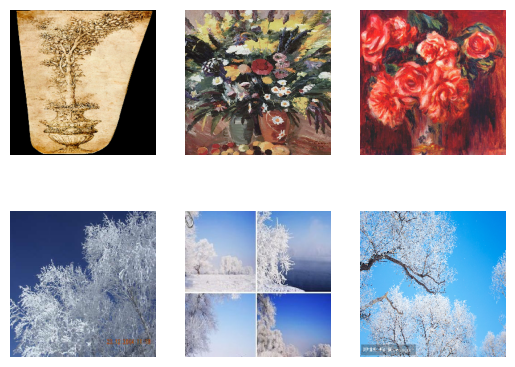

In [22]:
# plot source images
n_samples = 3
for i in range(n_samples):
	plt.subplot(2, n_samples, 1 + i)
	plt.axis('off')
	plt.imshow(dataA[i].astype('uint8'))
# plot target image
for i in range(n_samples):
	plt.subplot(2, n_samples, 1 + n_samples + i)
	plt.axis('off')
	plt.imshow(dataB[i].astype('uint8'))
plt.show()

In [23]:
# load image data
data = [dataA, dataB]

print('Loaded', data[0].shape, data[1].shape)

#Preprocess data to change input range to values between -1 and 1
# This is because the generator uses tanh activation in the output layer
#And tanh ranges between -1 and 1
def preprocess_data(data):
	# load compressed arrays
	# unpack arrays
	X1, X2 = data[0], data[1]
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

Loaded (500, 256, 256, 3) (500, 256, 256, 3)


In [24]:
dataset = preprocess_data(data)

In [25]:
#from cycleGAN_model import define_generator, define_discriminator, define_composite_model, train
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# generator: A -> B
g_model_AtoB = define_generator(image_shape)
# generator: B -> A
g_model_BtoA = define_generator(image_shape)
# discriminator: A -> [real/fake]
d_model_A = define_discriminator(image_shape)
# discriminator: B -> [real/fake]
d_model_B = define_discriminator(image_shape)
# composite: A -> B -> [real/fake, A]
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
# composite: B -> A -> [real/fake, B]
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [26]:
from datetime import datetime 
start1 = datetime.now() 
# train models
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset, epochs=5)

stop1 = datetime.now()
#Execution time of the model 
execution_time = stop1-start1
print("Execution time is: ", execution_time)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 24ms/step
Iteration>837, dA[0.150,0.116] dB[0.363,0.258] g[7.609,8.763]
1/1 [==============================] - 0s 26ms/step
Iteration>838, dA[0.075,0.098] dB[0.044,0.046] g[6.677,6.762]
1/1 [==============================] - 0s 39ms/step
Iteration>839, dA[0.072,0.056] dB[0.045,0.124] g[8.604,9.445]
1/1 [==============================] - 0s 23ms/step
Iteration>840, dA[0.062,0.067] dB[0.387,0.027] g[7.065,7.449]
1/1 [==============================] - 0s 23ms/step
Iteration>841, dA[0.036,0.134] dB[0.022,0.103] g[5.964,5.593]
1/1 [==============================] - 0s 23ms/step
Iteration>842, dA[0.085,0.048] dB[0.029,0.021] g[7.685,7.616]
1/1 [==============================] - 0s 23ms/step
Iteration>843, dA[0.083,0.123] dB[0.081,0.021] g[8.581,8.254]
1/1 [==============================] - 0s 24ms/step
Iteration>844, dA[0.026,0.030] dB[0.157,0.143] g[8.801,11.443]
1/1 [==============================]

>Saved: g_model_AtoB_002500.h5 and g_model_BtoA_002500.h5
Execution time is:  1:36:28.826589


In [27]:
############################################

# Use the saved cyclegan models for image translation
#from instancenormalization import InstanceNormalization  
from keras.models import load_model
from matplotlib import pyplot
from numpy.random import randint

In [28]:
# select a random sample of images from the dataset
def select_sample(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	return X

In [29]:
# plot the image, its translation, and the reconstruction
def show_plot(imagesX, imagesY1, imagesY2):
	images = vstack((imagesX, imagesY1, imagesY2))
	titles = ['Real', 'Generated', 'Reconstructed']
	# scale from [-1,1] to [0,1]
	images = (images + 1) / 2.0
	# plot images row by row
	#for i in range(len(images)):
		# define subplot
	#	pyplot.subplot(1, len(images), 1 + i)
		# turn off axis
	#	pyplot.axis('off')
		# plot raw pixel data
	#	pyplot.imshow(images[i])
		# title
	#	pyplot.title(titles[i])
	#pyplot.show()
	pyplot.imshow(imagesY1)

In [30]:
# load dataset
A_data = resample(dataA_all, 
                 replace=False,     
                 n_samples=50,    
                 random_state=42) # reproducible results

B_data = resample(dataB_all, 
                 replace=False,     
                 n_samples=50,    
                 random_state=42) # reproducible results

A_data = (A_data - 127.5) / 127.5
B_data = (B_data - 127.5) / 127.5

In [36]:
def show_plot(imagesX, imagesY1, imagesY2):
    # Extract the individual image from the array
    imageX = imagesX[0]
    imageY1 = imagesY1[0]
    imageY2 = imagesY2[0]

    # Create the plot
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(imageX)
    axs[0].axis('off')
    axs[0].set_title('Image X')

    axs[1].imshow(imageY1)
    axs[1].axis('off')
    axs[1].set_title('Image Y1')

    axs[2].imshow(imageY2)
    axs[2].axis('off')
    axs[2].set_title('Image Y2')

    plt.show()


1/1 [==============================] - 1s 738ms/step


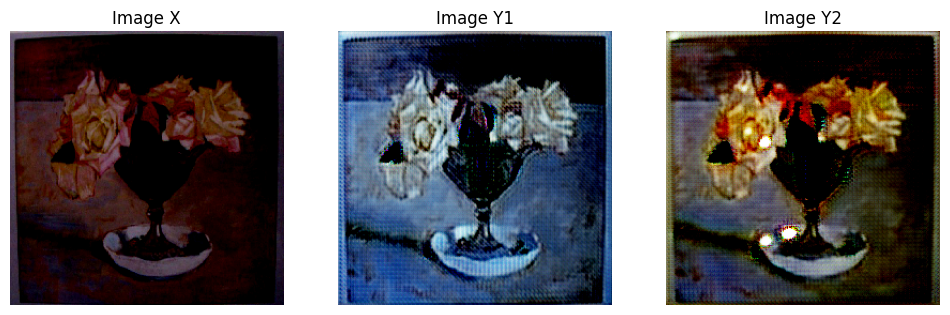

1/1 [==============================] - 0s 27ms/step


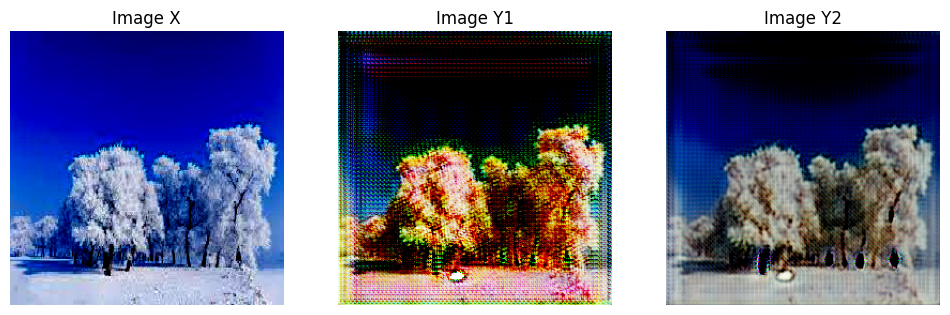

In [38]:
# load the models
cust = {'InstanceNormalization': InstanceNormalization}
model_AtoB = load_model('/content/g_model_AtoB_002500.h5', cust)
model_BtoA = load_model('/content/g_model_BtoA_002500.h5', cust)


# plot A->B->A (Flower to Rime to Flower)
A_real = select_sample(A_data, 1)
B_generated  = model_AtoB.predict(A_real)
A_reconstructed = model_BtoA.predict(B_generated)
show_plot(A_real, B_generated, A_reconstructed)
# plot B->A->B (Rime to Flower to Rime)
B_real = select_sample(B_data, 1)
A_generated  = model_BtoA.predict(B_real)
B_reconstructed = model_AtoB.predict(A_generated)
show_plot(B_real, A_generated, B_reconstructed)

1/1 [==============================] - 2s 2s/step


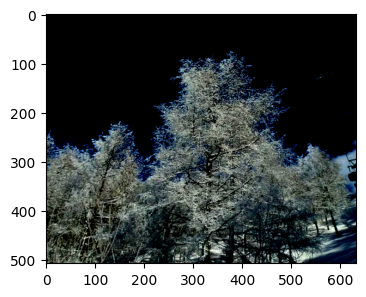

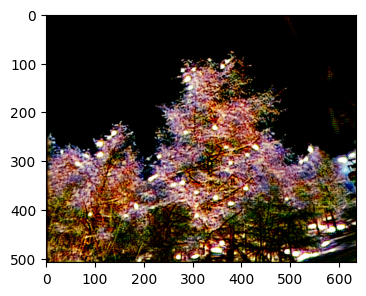

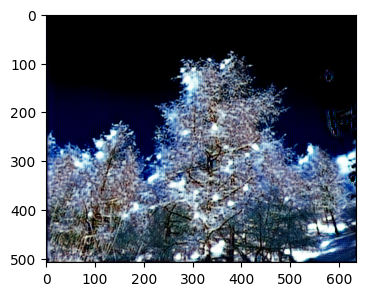

In [39]:
##########################
#Load a single custom image
test_image = load_img('/content/drive/MyDrive/Colab Notebooks/cycleGAN/testimages/bbb.jpg')
test_image = img_to_array(test_image)
test_image_input = np.array([test_image])  # Convert single image to a batch.
test_image_input = (test_image_input - 127.5) / 127.5
#process images into same pixel
# plot B->A->B (Rime to Flower to Photo)
flower_generated  = model_BtoA.predict(test_image_input)
photo_reconstructed = model_AtoB.predict(flower_generated)
#show_plot(test_image_input, flower_generated, photo_reconstructed)
plt.figure(figsize=(4,4))
	# scale from [-1,1] to [0,1]
im = (test_image_input[0] + 1) / 2.0
plt.imshow(test_image_input[0])
plt.show()

plt.figure(figsize=(4,4))
	# scale from [-1,1] to [0,1]
im = (flower_generated[0] + 1) / 2.0
plt.imshow(flower_generated[0])
plt.show()

plt.figure(figsize=(4,4))
	# scale from [-1,1] to [0,1]
im = (photo_reconstructed[0] + 1) / 2.0
plt.imshow(photo_reconstructed[0])
plt.show()